In [30]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [31]:
train_data = datasets.MNIST (
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST (
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [32]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [33]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [34]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [35]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [36]:
loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}

In [37]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1ee760df910>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1ee022a1010>}

In [38]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # doesn't change the shape of the data
        self.fc1 = nn.Linear(320, 50) # 20 * 4 * 4 (20 channels, 2 convolutions)
        self.fc2 = nn.Linear(50, 10) # last layer must be 10 output neurons

    def forward(self, x): # defines activations
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # 20 * 4 * 4 (20 channels, 2 convolutions)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # so its triggered only during training, not evaluation
        x = self.fc2(x)

        return F.softmax(x)

In [39]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device) # to have them on gpu

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train() # model to train mode
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device) # to have them on gpu
        optimizer.zero_grad()
        output = model(data) # prediction
        loss = loss_fn(output, target) # prediction to target
        loss.backward() # compute gradient of the loss with respect to the parameters
        optimizer.step() # update the parameters according to the computed gradients and the learning rate

        if (batch_idx % 20 == 0):
            print(f'Train epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')
            # epoch
            # how many of how many are already processed of epochs
            # how many of how many are already processed of batches
            # loss

def test():
    model.eval() # model to evaluation mode

    test_loss = 0
    correct = 0

    with torch.no_grad(): # disable grad since in eval and no backward calling
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device) # to have them on gpu
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item() # we need to shape the target the same way as pred

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')
    # Average loss
    # Accuracy: correct classified instances divided by the total instances

In [40]:
for epoch in range(1, 11):
    train(epoch)
    test()

C:\Users\User\AppData\Local\Temp\ipykernel_17088\1603986484.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train epoch: 1 [0/60000 (0%)]	2.301711
Train epoch: 1 [2000/60000 (3%)]	2.294564
Train epoch: 1 [4000/60000 (7%)]	2.161079
Train epoch: 1 [6000/60000 (10%)]	2.033225
Train epoch: 1 [8000/60000 (13%)]	1.905081
Train epoch: 1 [10000/60000 (17%)]	1.883372
Train epoch: 1 [12000/60000 (20%)]	1.916981
Train epoch: 1 [14000/60000 (23%)]	1.877374
Train epoch: 1 [16000/60000 (27%)]	1.713758
Train epoch: 1 [18000/60000 (30%)]	1.730513
Train epoch: 1 [20000/60000 (33%)]	1.670714
Train epoch: 1 [22000/60000 (37%)]	1.722477
Train epoch: 1 [24000/60000 (40%)]	1.665545
Train epoch: 1 [26000/60000 (43%)]	1.663201
Train epoch: 1 [28000/60000 (47%)]	1.647442
Train epoch: 1 [30000/60000 (50%)]	1.759225
Train epoch: 1 [32000/60000 (53%)]	1.584877
Train epoch: 1 [34000/60000 (57%)]	1.695922
Train epoch: 1 [36000/60000 (60%)]	1.595092
Train epoch: 1 [38000/60000 (63%)]	1.674335
Train epoch: 1 [40000/60000 (67%)]	1.670383
Train epoch: 1 [42000/60000 (70%)]	1.641192
Train epoch: 1 [44000/60000 (73%)]	1.649399

In [41]:
device

device(type='cpu')

In [45]:
# Save the model
torch.save(model.state_dict(), '    .pth')

Prediction: 7


C:\Users\User\AppData\Local\Temp\ipykernel_17088\1603986484.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


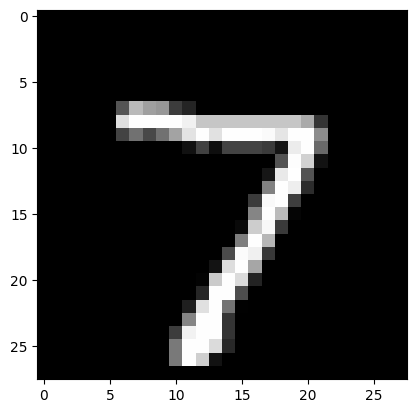

In [46]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]

data = data.unsqueeze(0).to(device) # means we are adding batch dimension so we can entry not as 1 data point but as a collection of 1 data point

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy() # opposite operation, so we unpack layers, we unpack the image from the data, then we squeeze out the channel dimensions

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# # Now, let's use the saved model to classify images from an input folder
# import os
# import cv2

# # Load the saved model
# saved_model = CNN().to(device)
# saved_model.load_state_dict(torch.load('digit_recog_model.pth'))
# saved_model.eval()

# # Define a function to classify an image
# def classify_image(image_path):
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     image_tensor = torch.tensor(image / 255., dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Convert to tensor and add batch dimension
#     output = saved_model(image_tensor)
#     prediction = output.argmax(dim=1, keepdim=True).item()
#     return prediction

# # Path to the input folder containing images to classify
# input_folder = r'C:\Users\User\Desktop\Project\Code\yolov5\inputs\test_ocr'

# # Classify images in the input folder
# for filename in os.listdir(input_folder):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         image_path = os.path.join(input_folder, filename)
#         prediction = classify_image(image_path)
#         print(f'Image: {filename}, Prediction: {prediction}')